# Analysis of admixfrog for allentoft et al
Ran admixfrog on all samples with no flags in allentoft et al; here I explore results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from plotnine import *
import sys
sys.path.append("../src/")
from src import legend_kwargs

def filter_output(df):    
    # Filter to remove the state annotations
    df = df.loc[df["type"] != "state"]
    # Remove any archaic calls that are shorter than 0.05 cM
    min_len = .05
    df = df.drop(df.loc[((df['map_len']  < min_len) & (df['target'] != 'AFR'))].index)
    return df

def plot_introgression(sample, suffix = "", drop_afr=False):
    # Read in and filter sample data
    df = pd.read_csv(f"../processed-data/admixfrog-allentoft/{sample}/{sample}.rle.xz")
    df = filter_output(df)
    # Read in chromosome length information df
    # NOTE: chromosome lengths are taken from https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg19&chromInfoPage=
    chromosomes = pd.read_csv("../src/chrom_lens.csv", index_col=0)
    chromosomes.drop(['X', 'Y'], inplace=True)
    chromosomes.reset_index(inplace=True)
    chromosomes["chrom"] = chromosomes["chrom"].astype(int)
    chromosomes['x'] = 0

    # color map for plotting
    colormap = {
        'AFR' : "darkgrey", 
        # 'AFR' : "lightgrey", 
        'NEA' : "c", 
        'DEN' : "y", 
        'AFRNEA' : "magenta", 
        'AFRDEN' : "lime", 
        'NEADEN' : "orange",
    }
    if drop_afr:
        # Skip plotting AFR ancestry
        df = df[df['target'] != "AFR"]
    p1 = (
        ggplot()
        + geom_segment(
            aes(x='x', xend='length', y='chrom', yend='chrom'), 
            data=chromosomes, 
            color='grey', alpha=.2, size=5)
        + geom_segment(
            aes(x='pos', xend='pos_end', y='chrom', yend='chrom', color='target'), 
            size=5, 
            data=df)
        + scale_color_manual(values=colormap, na_value='grey')
        + scale_y_continuous(breaks=range(1, 23))
        + labs(x="Position [bp]", y="Chromosome", color="Ancestry", title=sample + suffix)
        + theme_bw()
        + theme(panel_grid_major=element_blank(),  # Remove major gridlines
                panel_grid_minor=element_blank(),
                panel_border=element_blank())
    )
    p1.show()

# Read sample metadata
metadata = pd.read_csv("../processed-data/metadata_allentoft_et_al_2024.csv", index_col=0)
# Convert average ages to ints
ages = metadata["Age average"][~metadata["Age average"].isna()] # one sample doesn't have an age given...
ages = ages.str.replace(",", "_").astype(int)
metadata.loc[ages.index, "Age average"] = ages.values
# Get chromosome lengths
chromosomes = pd.read_csv("../src/chrom_lens.csv", index_col=0)
chromosomes.drop(['X', 'Y'], inplace=True)
chromosomes.reset_index(inplace=True)
chromosomes["chrom"] = chromosomes["chrom"].astype(int)
# Get sample info
samples = pd.read_csv("../processed-data/noflag.inds.txt", header=None, index_col=0)
samples = samples.index.tolist()

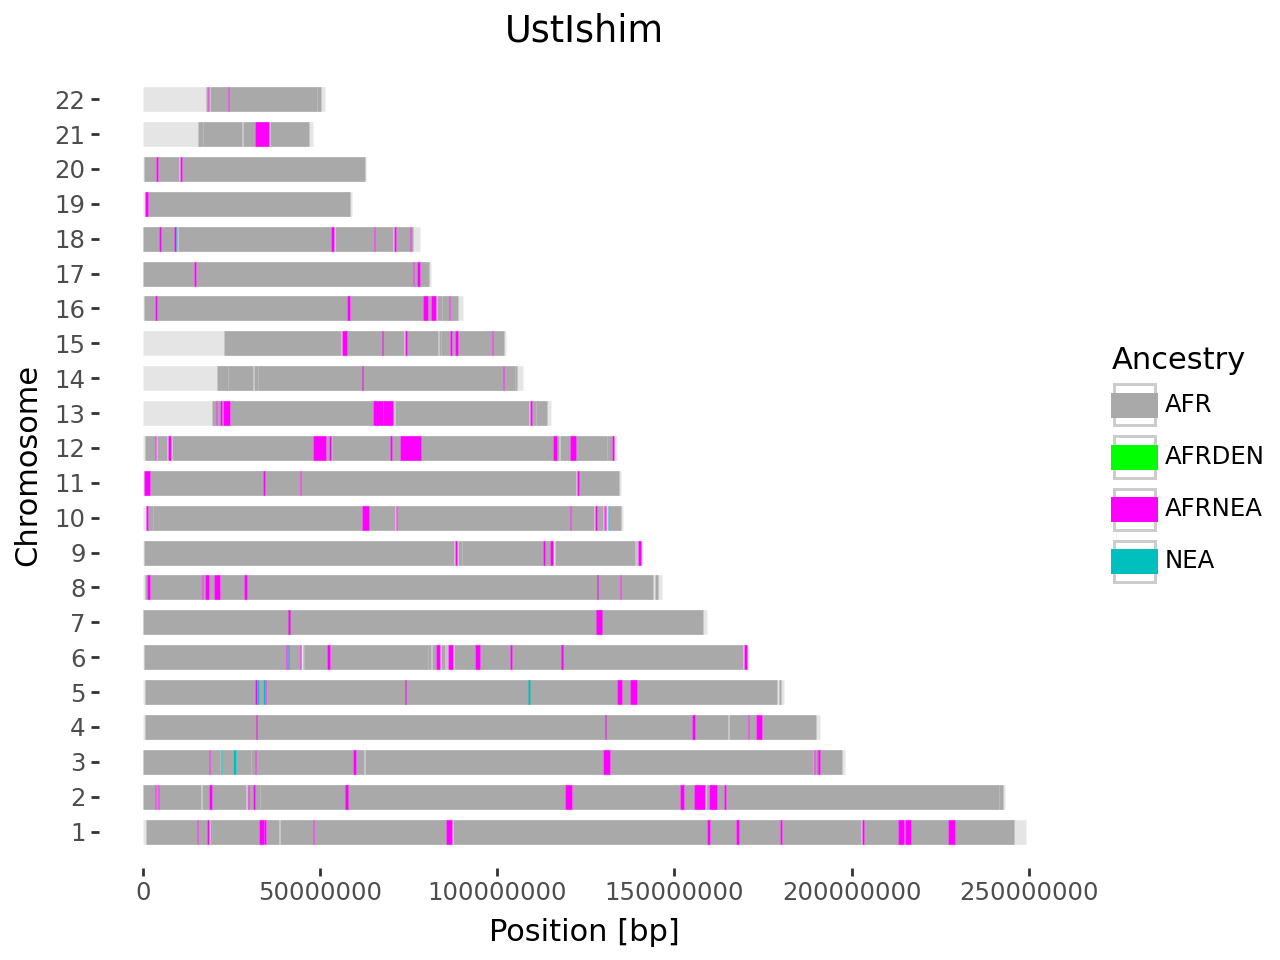

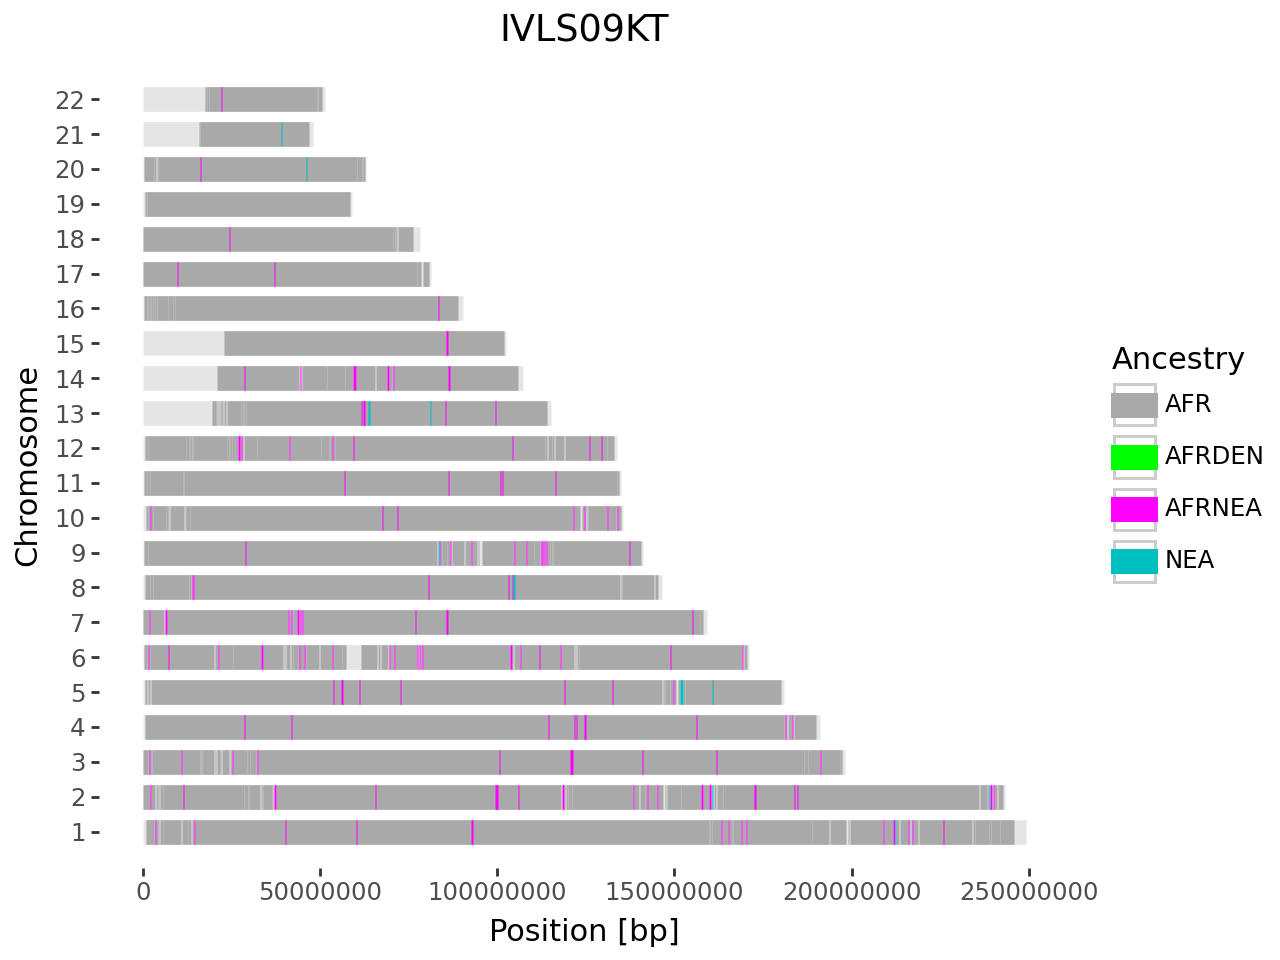

In [2]:
plot_introgression("UstIshim")
plot_introgression("IVLS09KT")

# plot_introgression("NEO823")


In [3]:
# udir = "../processed-data/admixfrog-allentoft/UstIshim/"
# for i in os.listdir(udir):
#     if ".xz" in i:
#         print(i)
#         display(pd.read_csv(udir + i))

In [5]:
def spatial_ancestry(anc="NEA"):
#     val

# sample = "baa01"
# anc = "NEA"
    transfer_cols = metadata.columns.tolist()
    # transfer_cols = ["Latitude", "Longitude", "Country", "Coverage", "Age average"]
    res_df = pd.DataFrame(columns=transfer_cols + [anc])
    # metadata["Age average"] = metadata["Age average"].str.replace(",", "_")

    for sample in samples:
        try:
            res2 = pd.read_csv(f"../processed-data/admixfrog-allentoft/{sample}/{sample}.res2.xz", index_col=0)
            pct_anc = res2.loc[anc, "mean"] * 100
            res_df.loc[sample, transfer_cols] = metadata.loc[sample, transfer_cols].values
            res_df.loc[sample, anc] = pct_anc
        except FileNotFoundError:
            pass

    # res_df["Age"] = res_df["Age"].astype(int)
    res_df.rename(columns={"Age average" : "Age"}, inplace=True)
    print("Samples read: ", res_df.shape[0])
    return res_df.dropna()

res_df = spatial_ancestry("NEA")

Samples read:  1492


## Spatial plots

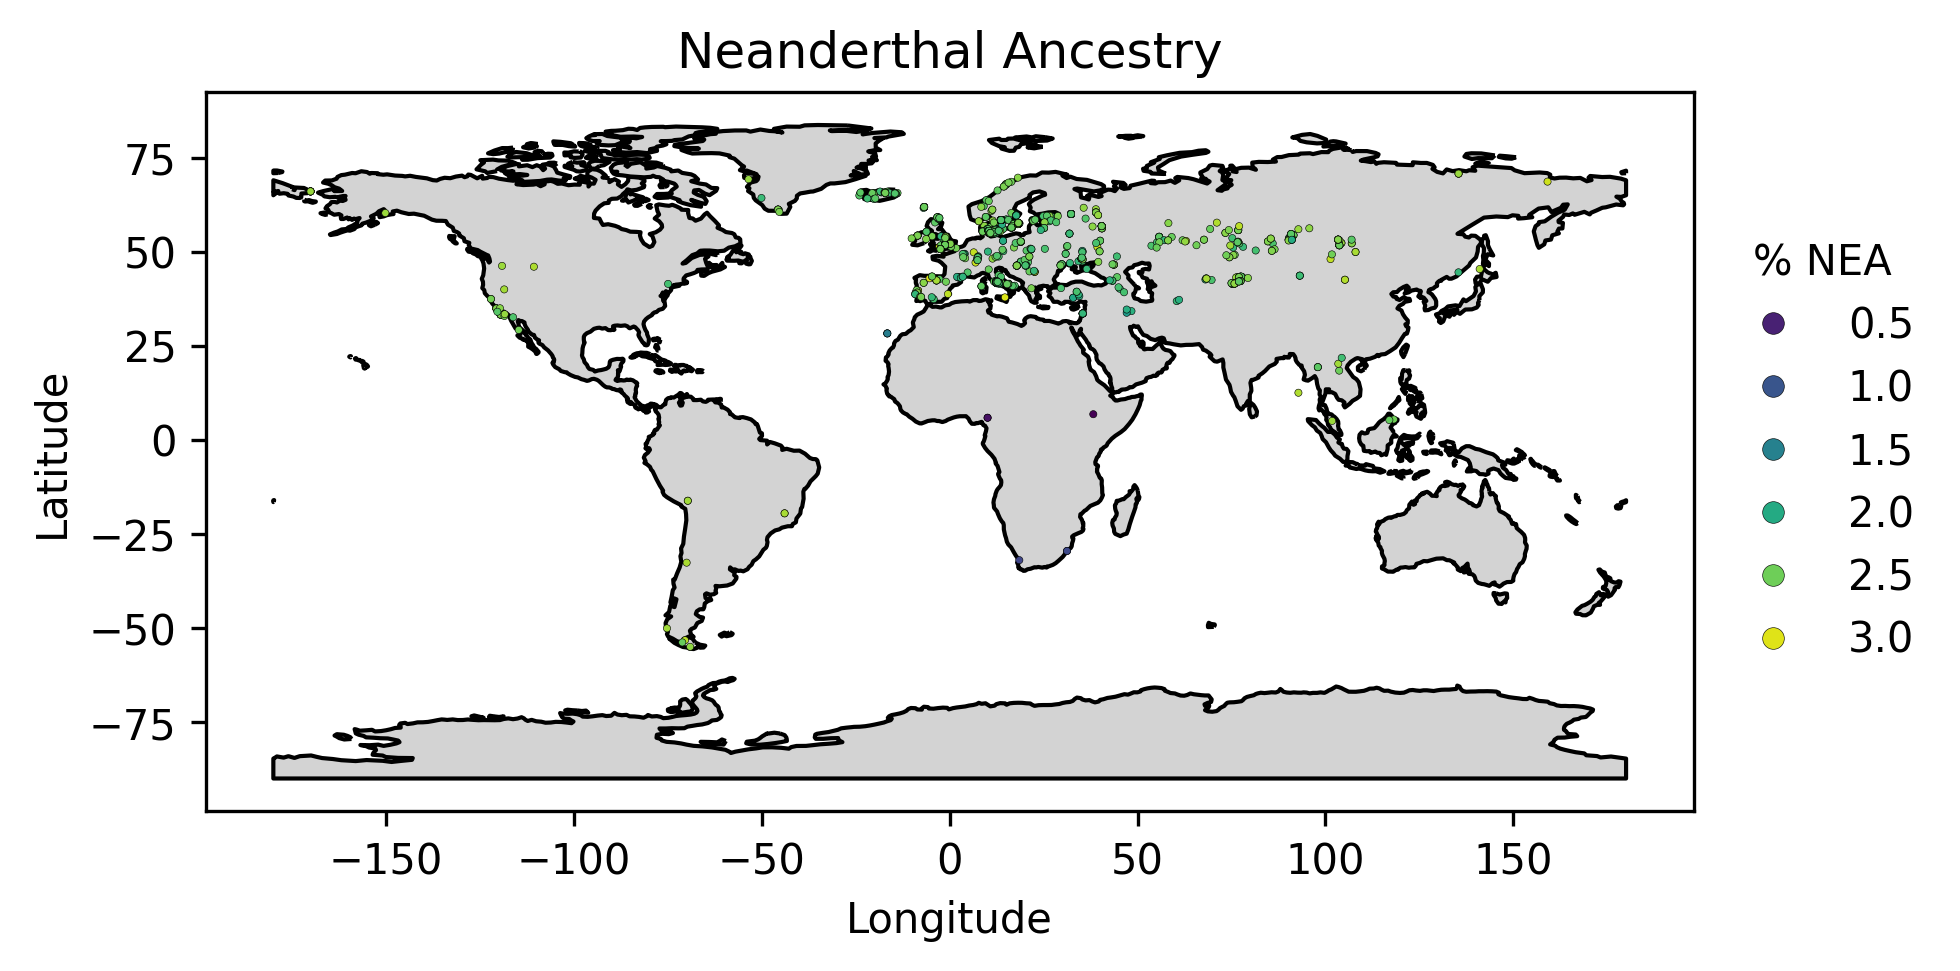

In [5]:
import geopandas as gpd
import geodatasets

anc = "NEA"
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

cmap = "viridis"

fig, ax = plt.subplots(dpi=300)
world.plot(
    edgecolor='k', facecolor='lightgrey',
    ax=ax,
    )

sns.scatterplot(
    res_df,
    y="Latitude", x="Longitude", hue=anc,
    edgecolor='k', 
    s=3, palette=cmap,
    ax=ax
    )
ax.set_title("Neanderthal Ancestry")
ax.legend(markerscale=3, title=f"% {anc}",  **legend_kwargs())
plt.show()

Samples read:  1492


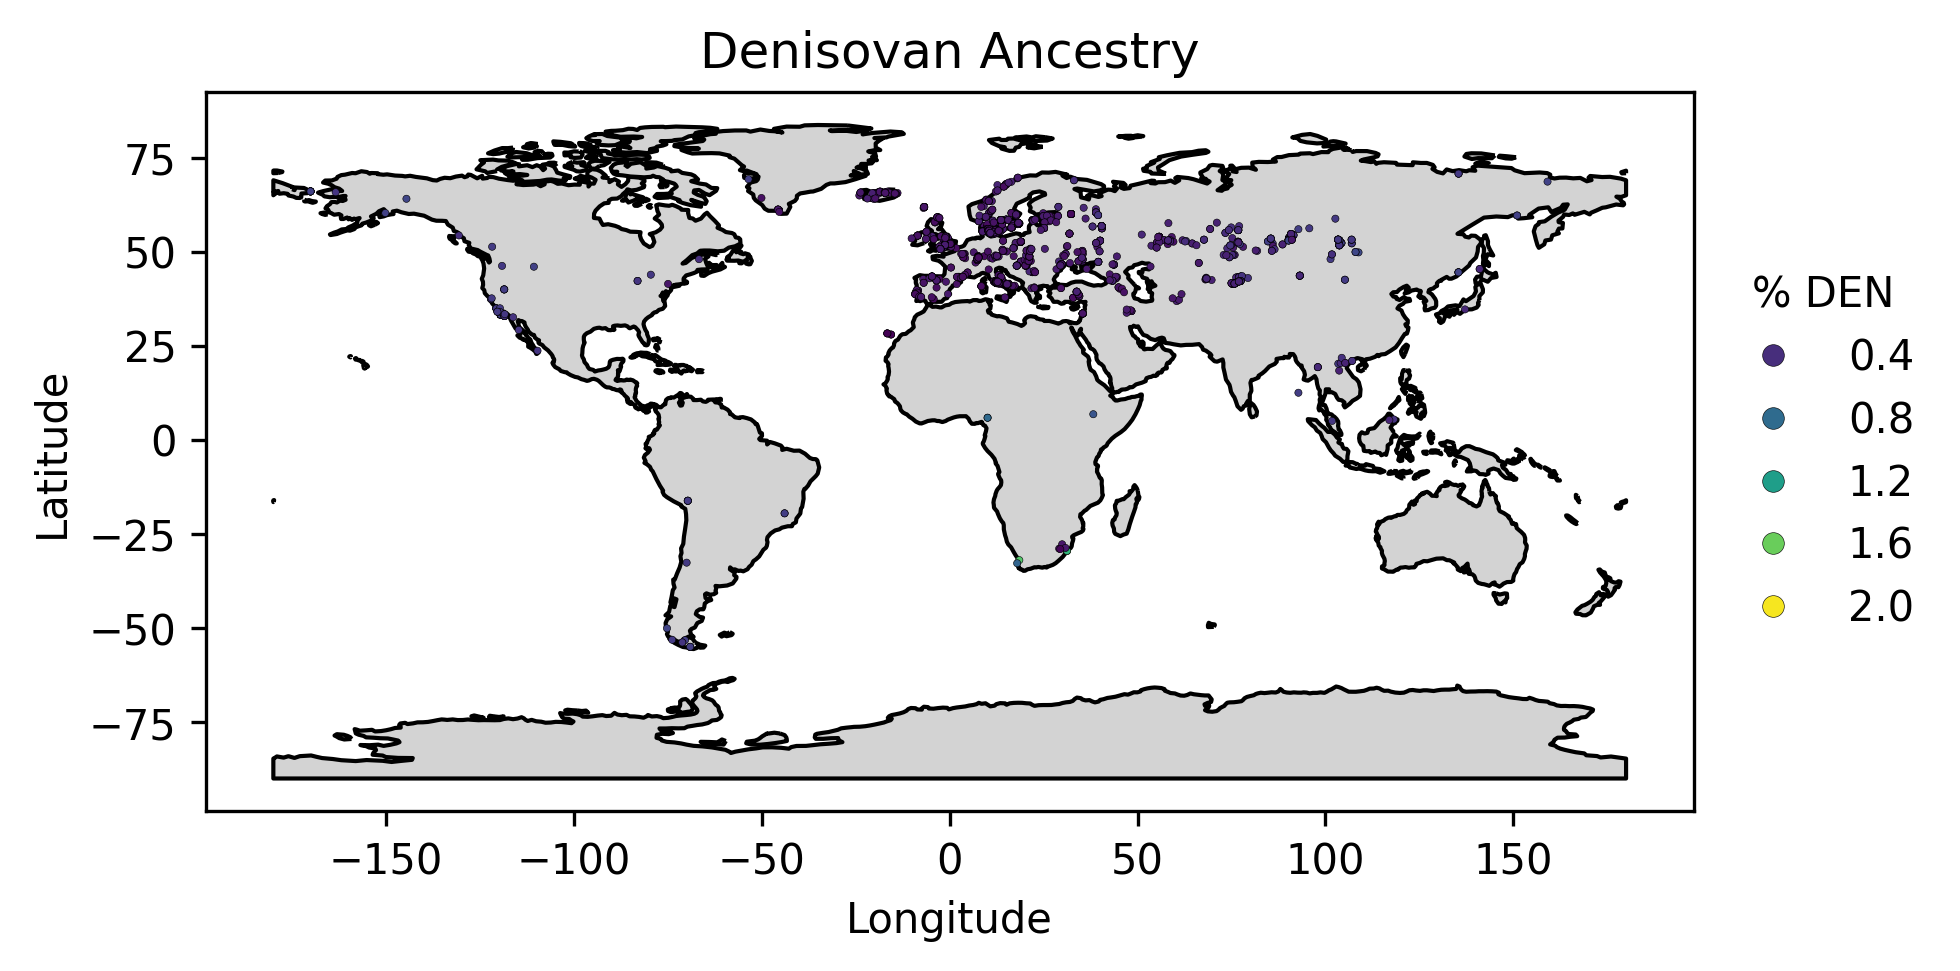

In [5]:
import geopandas as gpd
import geodatasets

anc = "DEN"
den_df = spatial_ancestry("DEN")
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

cmap = "viridis"

fig, ax = plt.subplots(dpi=300)
world.plot(
    edgecolor='k', facecolor='lightgrey',
    ax=ax,
    )

sns.scatterplot(
    den_df,
    y="Latitude", x="Longitude", hue=anc,
    edgecolor='k', 
    s=3, palette=cmap,
    ax=ax
    )
ax.set_title("Denisovan Ancestry")
ax.legend(markerscale=3, title=f"% {anc}",  **legend_kwargs())
plt.show()

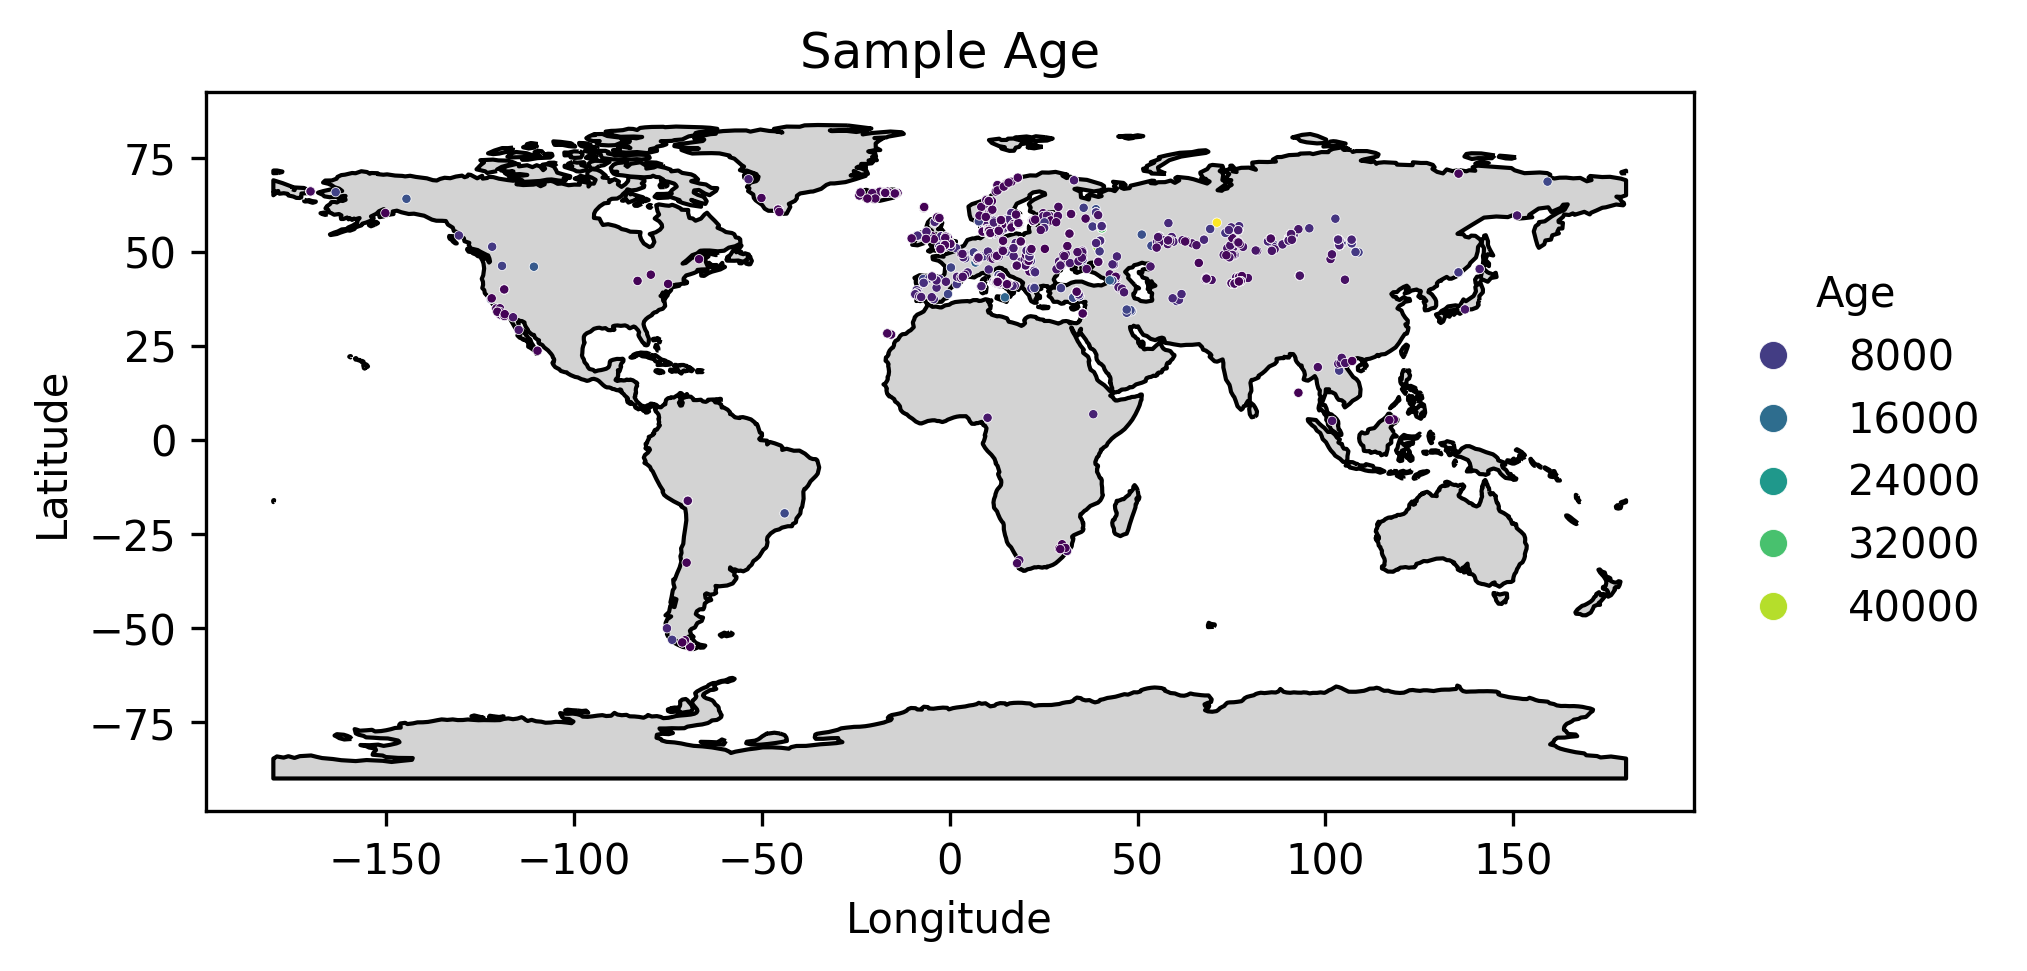

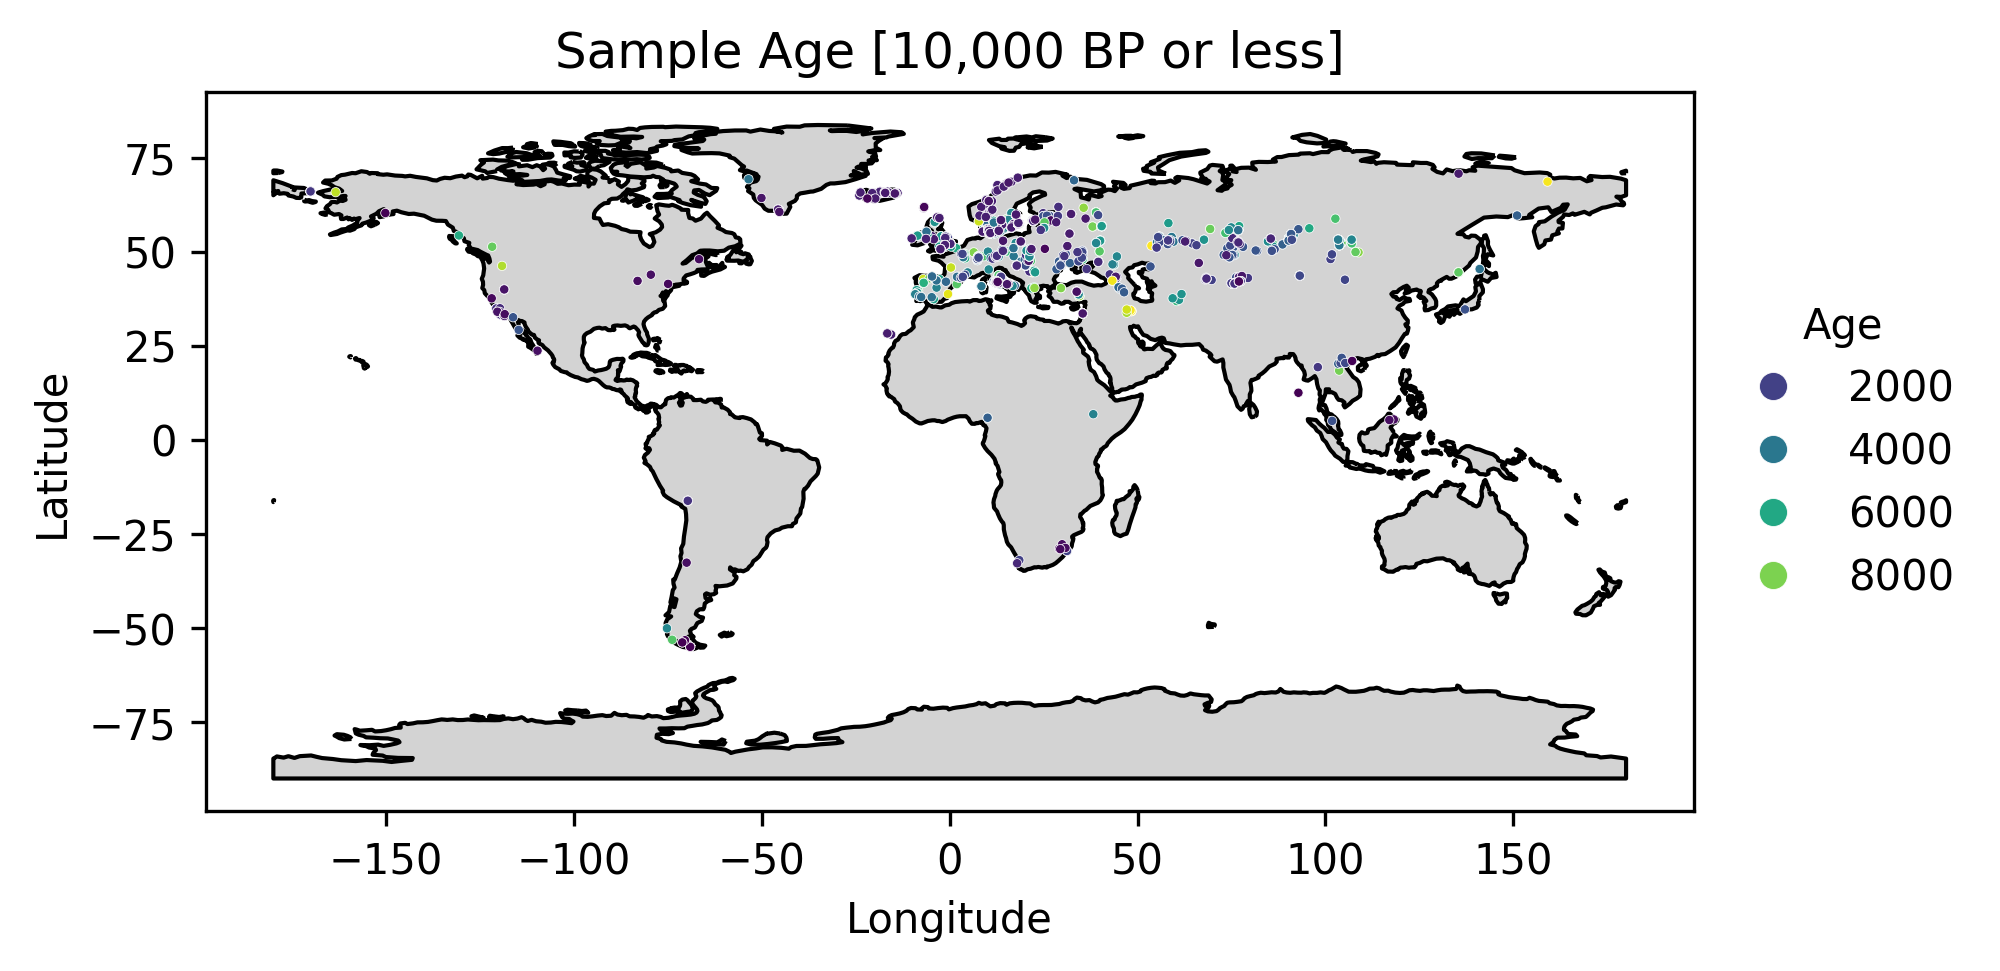

In [6]:
# world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

cmap = "viridis"

fig, ax = plt.subplots(dpi=300)
world.plot(
    edgecolor='k', facecolor='lightgrey',
    ax=ax,
    )

sns.scatterplot(
    res_df,
    y="Latitude", x="Longitude", hue="Age",
    # edgecolor=None, 
    s=5, palette=cmap,
    ax=ax,
    )

ax.legend(markerscale=3, title=f"Age",  **legend_kwargs())
ax.set_title("Sample Age")
plt.show()

# Only samples in past 10k yrs
fig, ax = plt.subplots(dpi=300)
world.plot(
    edgecolor='k', facecolor='lightgrey',
    ax=ax,
    )

sns.scatterplot(
    res_df[res_df["Age"] <= 10_000],
    y="Latitude", x="Longitude", hue="Age",
    # edgecolor=None, 
    s=5, palette=cmap,
    ax=ax,
    )

ax.legend(markerscale=3, title=f"Age",  **legend_kwargs())
ax.set_title("Sample Age [10,000 BP or less]")
plt.show()

In [28]:
# metadata[metadata["Age average"] > 10000].sort_values(by="Age average", ascending=False)
# metadata.sort_values(by="Age average", ascending=False).tail(50)

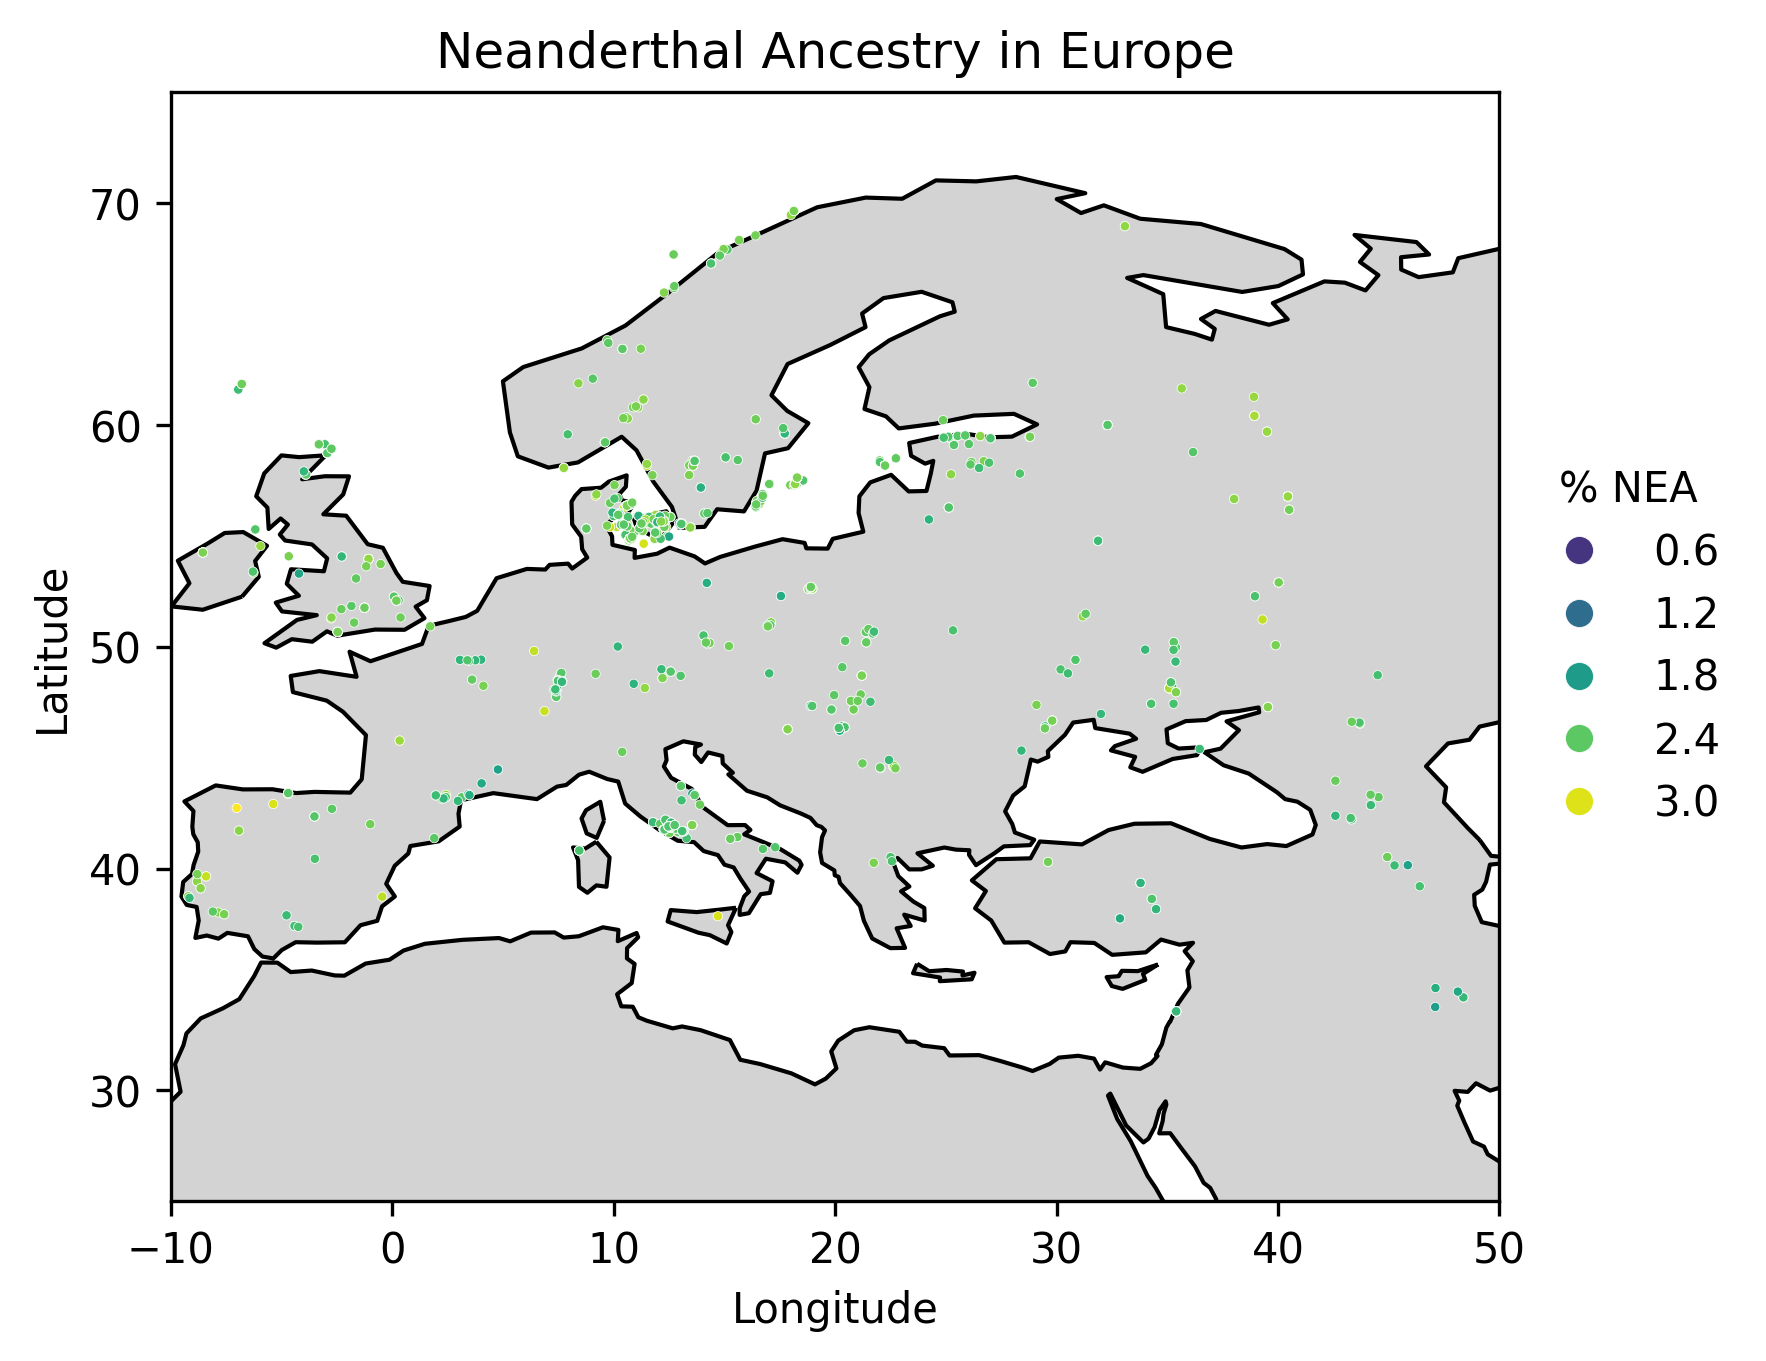

In [8]:
fig, ax = plt.subplots(dpi=300)
world.plot(
    edgecolor='k', facecolor='lightgrey',
    ax=ax,
    )

sns.scatterplot(
    res_df,
    y="Latitude", x="Longitude", hue="NEA",
    # edgecolor='k', 
    s=5, 
    palette=cmap,
    ax=ax
    )

ax.legend(markerscale=3, title=f"% NEA",  **legend_kwargs())

ax.set_xlim(-10, 50)
ax.set_ylim(25, 75)
ax.set_title("Neanderthal Ancestry in Europe")
plt.show()

In [9]:
# fig, ax = plt.subplots(dpi=300)
# world.plot(
#     edgecolor='k', facecolor='lightgrey',
#     ax=ax,
#     )

# sns.scatterplot(
#     res_df,
#     y="Latitude", x="Longitude", hue="Age",
#     edgecolor=None, s=5, palette='viridis',
#     ax=ax
#     )


# ax.legend(markerscale=3, title=f"% {anc}",  **legend_kwargs())

# plt.show()

## QC

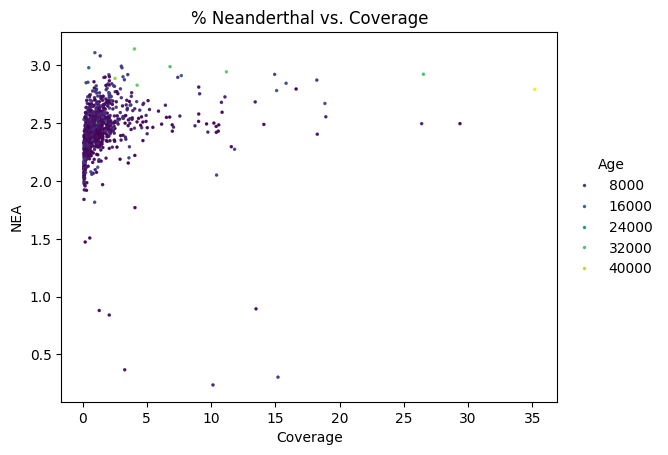

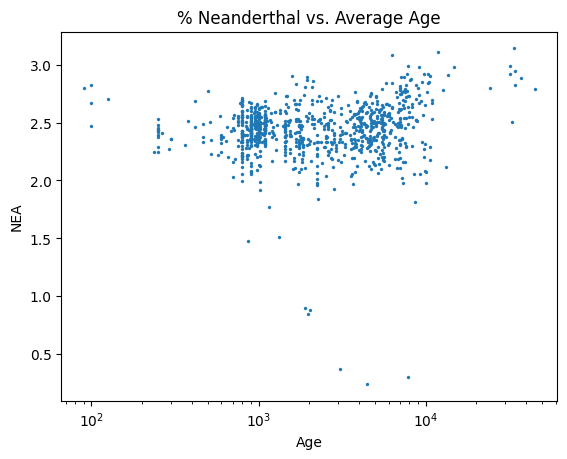

In [310]:

sns.scatterplot(
    res_df,
    x="Coverage", y="NEA", 
    hue="Age", palette="viridis",
    edgecolor=None, s=5)
plt.title("% Neanderthal vs. Coverage")
# plt.xscale("log")
plt.legend(title="Age", **legend_kwargs())
plt.show()

sns.scatterplot(
    res_df,
    x="Age", y="NEA",
    edgecolor=None, s=5)
plt.xscale("log")
plt.title("% Neanderthal vs. Average Age")
plt.show()

### Leo's Ancestry Estimates vs. Mine
14 Samples are present in both Allentoft et al. and Leo's datasets. Plotting our respective neanderthal ancestry estimates against each other, it looks like my results estimate higher introgression. We decided to use my estimates over Leo's. 

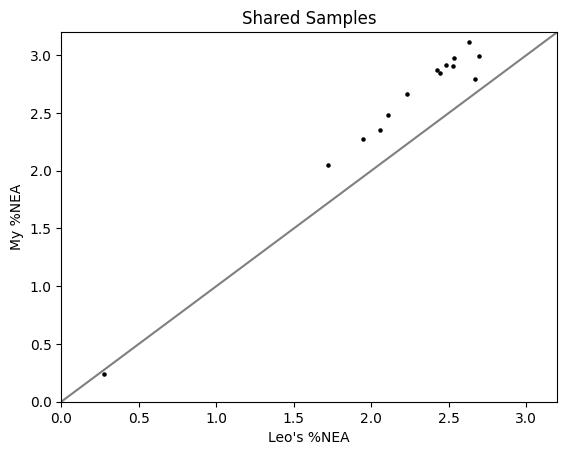

In [167]:
# Do Leo's ancestry estimates line up with mine for the samples we have in common?
repeated_samples = [
    'Bichon', 'Karelia', 'KK1', 'Loschbour', 'Mota', 'NE1', 'NE5', 'R11', 'R15', 
    'R7', 'Sumidouro5', 'UstIshim', 'WC1', 'Yana2']
iasi_ancestry = pd.read_csv("../processed-data/iasi_ancestry.csv", index_col=0)

metadata_leo = pd.read_csv("../processed-data/iasi_metadata.csv")
leo_to_orig = dict(metadata_leo[
    ["Sample Name in origina publication", "Sample name this study"]].values)

my_vals, leo_vals = [], []
for sample in repeated_samples:
    leo_vals.append(iasi_ancestry.loc[leo_to_orig[sample], "admixfrog_NEA_est"] * 100)
    res2_sample = pd.read_csv(
        f"../processed-data/admixfrog-allentoft/{sample}/{sample}.res2.xz",
        index_col=0)
    my_vals.append(res2_sample.loc["NEA", "mean"] * 100)
plt.scatter(leo_vals, my_vals, s=5, c='k')

vmax = 3.2
plt.plot([0, vmax], [0, vmax], c='k', alpha=0.5)
plt.title("Shared Samples")
plt.xlabel("Leo's %NEA")
plt.ylabel("My %NEA")
plt.xlim(0, vmax)
plt.ylim(0, vmax)
plt.show()

### B-Statistics
Located in `/global/scratch/p2p3/pl1_moorjani/SHARED_LAB/DATASETS/resources/hg19/B-stat/bstat_hg19.txt`

Columns are chrom, from, to, B-stat*1000 [I am just calling this "B"]

From the paper: "We binned the B-scores in five windows (0-200, 201-400, 401-600, 601-800 and 801-1000) and calculated the average amount of basepairs covered by Neandertal ancestry for all genomic windows in each of the B-score bins."

In [150]:
bfilepath = "/global/scratch/p2p3/pl1_moorjani/SHARED_LAB/DATASETS/resources/hg19/B-stat/bstat_hg19.txt"
bdf = pd.read_csv(bfilepath, sep="\t", header=None)
bdf.columns=["chrom", "from", "to", "B"]
# Convert chrom to int
bdf["chrom"] = bdf["chrom"].str.split("chr").str[1].astype(int)
# Bin B-statistics as in paper 
b_bin = lambda b: np.maximum(b - 1, 0) // 200
bdf["B_bin"] = bdf["B"].apply(b_bin)
# Convert positions of B-statistics to cM
# bdf.loc[:, ["from", "to"]] = bdf.loc[:, ["from", "to"]] / 1e6 / 0.05

In [149]:
# bdf.head()
# bdf.loc[:, ["from", "to"]] = bdf.loc[:, ["from", "to"]].astype(np.float64)
# print(bdf.dtypes)
# bdf.loc[:, ["from", "to"]] = bdf.loc[:, ["from", "to"]] / 1e6 / 0.05
# bdf.dtypes


chrom    int64
from     int64
to       int64
B        int64
B_bin    int64
dtype: object


/tmp/ipykernel_3563384/3756318186.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2.00020000e-01 8.95788000e+00 1.30386200e+01 ... 1.02416688e+03
 1.02448916e+03 1.02488146e+03]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/tmp/ipykernel_3563384/3756318186.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[   8.95786   13.0386    14.83134 ... 1024.48914 1024.88144 1024.89132]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


chrom      int64
from     float64
to       float64
B          int64
B_bin      int64
dtype: object

In [133]:
runs = pd.read_csv('../processed-data/admixfrog-allentoft/UstIshim/UstIshim.rle.xz')
runs = runs[runs["type"] != "state"]
runs[runs["target"].isin(["NEA", "AFRNEA"])]

,chrom,start,end,score,target,type,map,pos,id,map_end,pos_end,id_end,len,map_len,pos_len,nscore
0,1,45804,46334,49.919550,AFRNEA,het,229.020,213134953,45804,231.670,214668583,46334,530,2.650,1533630,0.094188
1,1,46461,46931,44.549860,AFRNEA,het,232.305,215141568,46461,234.655,216853158,46931,470,2.350,1711590,0.094787
2,1,6595,6988,36.137239,AFRNEA,het,32.975,18183449,6595,34.940,18662964,6988,393,1.965,479515,0.091952
3,1,42614,42974,33.025333,AFRNEA,het,213.070,202846185,42614,214.870,203498166,42974,360,1.800,651981,0.091737
4,1,23044,23355,29.289724,AFRNEA,het,115.220,85420077,23044,116.775,87177835,23355,311,1.555,1757758,0.094179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,5,208700,208775,6.813777,NEA,homo,50.245,32225019,208700,50.620,32646171,208775,75,0.375,421152,0.090850
710,5,221422,221514,6.363549,NEA,homo,113.855,108634861,221422,114.315,109177148,221514,92,0.460,542287,0.069169
711,6,251816,251829,1.139867,NEA,homo,60.365,40782854,251816,60.430,40889659,251829,13,0.065,106805,0.087682
712,6,253499,253505,0.345190,NEA,homo,68.780,44602477,253499,68.810,44639229,253505,6,0.030,36752,0.057532


In [296]:
# TODO: Reformat the B-statistics file to aggregate consecutive sections falling into the same B-bin
bin_cts = np.zeros(5)

run = runs.iloc[0].copy()
# run["start"] = 1175585
# run["end"] = 1178792 - 10
# , "end"]] = [1175585, 1177934-10]
# display(run[["chrom", "start", "end"]])
def _count_run(run):
    b_run = bdf[
        (run["start"] >= bdf["from"]) &
        # (run["end"] > bdf["to"]) &
        (run["chrom"] == bdf["chrom"])].iloc[-1]
    # display(b_run, b_run.name + 1)
    b_end = b_run["to"]
    # Add the length of nt corresponding to this run of nt with a given b-bin
    # print(np.minimum(b_end, run["end"]), run["start"], np.minimum(b_end, run["end"]) - run["start"])
    bin_cts[b_run["B_bin"]] += (np.minimum(b_end, run["end"]) - run["start"])
    # If the ancestry run goes into another B bin, start counting that
    while run["end"] > b_end:
        # print(f"{run['end']} > {b_end} == {run['end'] > b_end}")
        b_run = bdf.iloc[b_run.name + 1]
        assert b_run["chrom"] == run["chrom"], "Ancestry run exceeds calculated B-statistic position"
        # print(b_run["to"])
        bin_cts[b_run["B_bin"]] += np.minimum(b_run["to"], run["end"]) - b_run["from"] + 1
        b_end = b_run["to"]


_count_run(run)
# Increment the count of nt in the bin
# if run["end"] > b_end:


In [297]:
bin_cts = np.zeros(5)
for _, run in runs.iterrows():
    _count_run(run)
bin_cts


IndexError: single positional indexer is out-of-bounds

In [303]:
# bdf[
#     (run["start"] >= bdf["from"]) &
#     # (run["end"] > bdf["to"]) &
#     (run["chrom"] == bdf["chrom"])]
run
bdf.groupby("chrom")["from"].min()

chrom
1        10001
2        10001
3        60001
4        10001
5        10000
6        60000
7       172198
8        10001
9        10001
10       60000
11       60000
12      145739
13    19020000
14    19000000
15    22326705
16       60001
17           1
18       10001
19       60001
20       60001
21    10697896
22    16050000
Name: from, dtype: int64

In [290]:
print(1413 + 926)
run['end'] - run['start']

2339


3197

In [294]:
print(f"Expected: 4: {1176998 - 1175585}, 3: {(1178792 - 10) - 1176999 + 1}")
print(bin_cts)

bdf.iloc[110:113]
# run[["start", "end"]] = [0, 0]
# run["start"] = 100

Expected: 4: 1413, 3: 1784
[  0.   0.   0.   0. 530.]


,chrom,from,to,B,B_bin
110,1,1175585,1176998,804,4
111,1,1176999,1177934,799,3
112,1,1177935,1178792,794,3


# Bins matrix

In [1]:
# Script to make sample by bin matrix for a given chromosome
import numpy as np
import pandas as pd
import sys

chrom = 1
# chrom = sys.argv[1]

# Read sample metadata
metadata = pd.read_csv(
    "../processed-data/metadata_allentoft_et_al_2024.csv", index_col=0)

# Convert average ages to ints
ages = metadata["Age average"][~metadata["Age average"].isna()] # one sample doesn't have an age given...
ages = ages.str.replace(",", "_").astype(int)
metadata.loc[ages.index, "Age average"] = ages.values
# Get samples with no flags
samples = pd.read_csv(
    "../processed-data/noflag.inds.txt", header=None, index_col=0)
samples = samples.index.tolist()
sample_order = (
    metadata.loc[samples]
    .dropna(subset="Age average") # Need to get rid of the one ageless sample
    .sort_values(by="Age average", ascending=False)
    .index.tolist())

# Now, let's start reading in the bin files
data_dir = "../processed-data/admixfrog-allentoft"

sample_by_bin = pd.DataFrame()
for sample in sample_order[:5]:
    bins = pd.read_csv(f"{data_dir}/{sample}/{sample}.bin.xz")
    bins = bins[bins["chrom"] == chrom]
    sample_by_bin.loc[sample, bins["map"].unique()] = (
        bins["NEA"] + bins["AFRNEA"]).values
# sample_by_bin.to_csv(f"../processed-data/sample_by_bin/chr{chrom}.csv.gz")
# TODO: Incorporate Leo's additional samples

# data_dir = "../processed-data/admixfrog-allentoft"

# chrom = 22

# sample_by_bin = pd.DataFrame()
# for sample in sample_order[:5]:
#     bins = pd.read_csv(f"{data_dir}/{sample}/{sample}.bin.xz")
#     bins = bins[bins["chrom"] == chrom]
#     sample_by_bin.loc[sample, bins["map"].unique()] = (bins["NEA"] + bins["AFRNEA"]).values
# # sample_by_bin.to_csv(f"../processed-data/sample_by_bin/chr{chrom}.csv.gz")

In [43]:
# WE NEED LEO AGES TO SORT FINAL MATRIX
ages_leo = pd.read_csv("../processed-data/iasi_ages.csv")
# The Stuttgart sample doesn't have a mean age, but does have upper and lower 
# bounds, so I'm just manually calculating from that. 
stuttgart = ages_leo.loc[ages_leo["Sample"]=="Stuttgart_LBK"]
ages_leo.loc[ages_leo["Sample"]=="Stuttgart_LBK", "Most Likely Date Mean"] = (
    stuttgart[
        ["Most Likely Date Lower (95.5 % CI)", 
        "Most Likely Date Upper (95.5 % CU)"]].mean(axis=1))
# Reformat age df
ages_leo = (ages_leo
    # .drop(columns="Sample")
    # .set_index("admixfrog_sample_name")
    .rename(columns={
        "Most Likely Date Mean" : "Age average",
        # "admixfrog_sample_name" : "Sample"
        })
    # .set_index("Sample")
    .loc[:, ["Sample", "Age average"]])
ancient_samples_leo = ages_leo["Sample"].tolist()
ages_leo["Age average"] = ages_leo["Age average"].astype(int)

# Remove the samples present in the Allentoft data from Leo's bin file
repeated_samples = [i for i in ancient_samples_leo if i in samples]
# Drop repeated samples from age df
ages_leo = ages_leo.loc[[i not in repeated_samples for i in ages_leo["Sample"]]]
# Concatenate with ages from Allentoft to order by age
ages_ancient = pd.concat(
    [
        metadata.loc[samples, "Age average"],
        ages_leo.set_index("Sample")
        # .copy()
        # .rename(columns={"Most Likely Date Mean" : "Age average"})
        # .set_index("Sample")
        ]).sort_values(by="Age average", ascending=False)
age_order = ages_ancient.index.tolist() + modern_samples

In [128]:
[i for i in sample_order if "K1" == i]

[]

In [3]:
leo_dir = "/global/scratch/p2p3/pl1_moorjani/jackdemaray/rotation/moorjani-rotation/processed-data/Admixfrog_files/Admixfrog_merged_bin_files/Shared_Map/Admixfrog_merged_bin_files"
leo_binfile = 'All_merged_bins_NEAarchaicadmixtureAPX.bin_called_map_Shared_Map_penatly_0.25_min_len0.2_0.05_min_len_pos0_0_min_n_all_SNP0_0_min_n_SNP0_0.csv'
bins_leo = pd.read_csv(f"{leo_dir}/{leo_binfile}")#, index_col=0)
# Read in Leo metadata
metadata_leo = pd.read_csv("../processed-data/iasi_metadata.csv")
# Rename samples in Leo's bin file to original study names
translator = dict(metadata_leo[
    ["Sample name this study", "Sample Name in origina publication"]].values)
bins_leo = bins_leo.rename(columns=translator)
# Get modern samples
modern_samples = [i for i in bins_leo.iloc[:, 4:].columns if i not in ancient_samples_leo]
# Remove repeated ancient samples
bins_leo.drop(columns=repeated_samples, inplace=True)
# Prune to selected chromosome
bins_leo = bins_leo[bins_leo["chrom"] == chrom]
# Reformat to sample x bins
bins_leo = bins_leo.set_index("map").iloc[:, 3:].T

In [5]:
# Aggregate samples by bins
pd.set_option('future.no_silent_downcasting', True)
samples_by_bins = pd.concat([sample_by_bin, bins_leo]).fillna(0.0).infer_objects(copy=False)
# .plot()

In [131]:
[i for i in age_order if "K1" == i]
[j for j in [i for i in samples_by_bins.index if i in age_order] if j == "K1"]

[]

In [138]:
pd.read_csv("../processed-data/sample_by_bin/chr1.csv.gz")

,Unnamed: 0
0,UstIshim
1,Kostenki
2,SII
3,SIII
4,SIV
...,...
1806,R2_R7
1807,KS5
1808,M2113
1809,M368


In [161]:
repeated_samples

['Bichon',
 'Karelia',
 'KK1',
 'Loschbour',
 'Mota',
 'NE1',
 'NE5',
 'R11',
 'R15',
 'R7',
 'Sumidouro5',
 'UstIshim',
 'WC1',
 'Yana2']

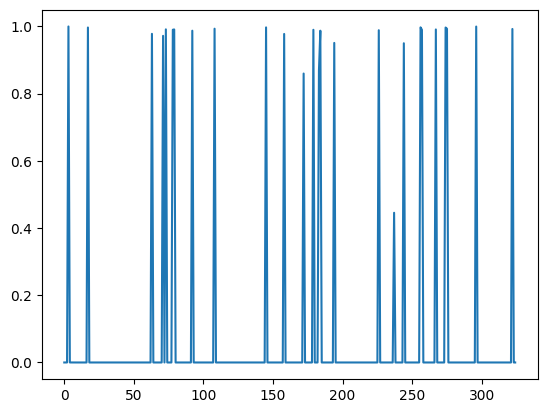

In [53]:
import matplotlib.pyplot as plt
# samples_by_bins.iloc[:, :5].plot()
# plt.show()
x = np.arange(len(samples_by_bins.index))
samples_by_bins
y = samples_by_bins.iloc[:, 101]
plt.plot(x, y,)
plt.show()

In [135]:
# Script to make sample by bin matrix for a given chromosome
import numpy as np
import pandas as pd
import sys

chrom = 1

print(f"Generating sample x bin for chromosome {chrom}")
# Read sample metadata
metadata = pd.read_csv(
    "../processed-data/metadata_allentoft_et_al_2024.csv", index_col=0)

# Convert average ages to ints
ages = metadata["Age average"][~metadata["Age average"].isna()] # one sample doesn't have an age given...
ages = ages.str.replace(",", "_").astype(int)
metadata.loc[ages.index, "Age average"] = ages.values
# Get allentoft samples with no flags
samples = pd.read_csv(
    "../processed-data/noflag.inds.txt", header=None, index_col=0)
samples = samples.index.tolist()
sample_order = (
    metadata.loc[samples]
    .dropna(subset="Age average") # Need to get rid of the one ageless sample
    .sort_values(by="Age average", ascending=False)
    .index.tolist())

# Now, let's start reading in the bin files
data_dir = "../processed-data/admixfrog-allentoft"
print("Reading bins...")
sample_by_bin = pd.DataFrame()
ctr = 0
for sample in sample_order[:5]:
    bins = pd.read_csv(f"{data_dir}/{sample}/{sample}.bin.xz")
    bins = bins[bins["chrom"] == chrom]
    sample_by_bin.loc[sample, bins["map"].unique()] = (
        bins["NEA"] + bins["AFRNEA"]).values
    ctr += 1
    print(f"\tFiles read: {ctr}", end="\r")
print("Reading Iasi et al. data...")
# WE NEED LEO AGES TO SORT FINAL MATRIX
ages_leo = pd.read_csv("../processed-data/iasi_ages.csv")
# The Stuttgart sample doesn't have a mean age, but does have upper and lower 
# bounds, so I'm just manually calculating from that. 
stuttgart = ages_leo.loc[ages_leo["Sample"]=="Stuttgart_LBK"]
ages_leo.loc[ages_leo["Sample"]=="Stuttgart_LBK", "Most Likely Date Mean"] = (
    stuttgart[
        ["Most Likely Date Lower (95.5 % CI)", 
        "Most Likely Date Upper (95.5 % CU)"]].mean(axis=1))
# Reformat age df
ages_leo = (ages_leo
    # .drop(columns="Sample")
    # .set_index("admixfrog_sample_name")
    .rename(columns={
        "Most Likely Date Mean" : "Age average",
        # "admixfrog_sample_name" : "Sample"
        })
    # .set_index("Sample")
    .loc[:, ["Sample", "Age average"]])
ancient_samples_leo = ages_leo["Sample"].tolist()
ages_leo["Age average"] = ages_leo["Age average"].astype(int)

# Remove the samples present in the Allentoft data from Leo's bin file
repeated_samples = [i for i in ancient_samples_leo if i in samples]
# Drop repeated samples from age df
ages_leo = ages_leo.loc[[i not in repeated_samples for i in ages_leo["Sample"]]]
# Concatenate with ages from Allentoft to order by age
ages_ancient = pd.concat(
    [
        metadata.loc[samples, "Age average"],
        ages_leo.set_index("Sample")
        # .copy()
        # .rename(columns={"Most Likely Date Mean" : "Age average"})
        # .set_index("Sample")
        ]).sort_values(by="Age average", ascending=False)


# Now let's read in Leo's bin data
leo_dir = "/global/scratch/p2p3/pl1_moorjani/jackdemaray/rotation/moorjani-rotation/processed-data/Admixfrog_files/Admixfrog_merged_bin_files/Shared_Map/Admixfrog_merged_bin_files"
leo_binfile = 'All_merged_bins_NEAarchaicadmixtureAPX.bin_called_map_Shared_Map_penatly_0.25_min_len0.2_0.05_min_len_pos0_0_min_n_all_SNP0_0_min_n_SNP0_0.csv'
bins_leo = pd.read_csv(f"{leo_dir}/{leo_binfile}")#, index_col=0)
# Read in Leo metadata
metadata_leo = pd.read_csv("../processed-data/iasi_metadata.csv")
# Rename samples in Leo's bin file to original study names
translator = dict(metadata_leo[
    ["Sample name this study", "Sample Name in origina publication"]].values)
bins_leo = bins_leo.rename(columns=translator)
# Get modern samples
modern_samples = [i for i in bins_leo.iloc[:, 4:].columns if i not in ancient_samples_leo]
age_order = ages_ancient.index.tolist() + modern_samples
# Remove repeated ancient samples
bins_leo.drop(columns=repeated_samples, inplace=True)
# Prune to selected chromosome
bins_leo = bins_leo[bins_leo["chrom"] == chrom]
# Reformat to sample x bins
bins_leo = bins_leo.set_index("map").iloc[:, 3:].T
print("Aggregating results...")
# Aggregate samples by bins
pd.set_option('future.no_silent_downcasting', True)
sample_by_bin = pd.concat([sample_by_bin, bins_leo]).fillna(0.0).infer_objects(copy=False)
# Order the samples
sample_by_bin = sample_by_bin.loc[[i for i in sample_by_bin.index if i in age_order]]
# Finally, save the results

Generating sample x bin for chromosome 1
Reading bins...
Reading Iasi et al. data...
Aggregating results...


In [140]:
sample_by_bin.to_csv(f"../processed-data/sample_by_bin/chr{chrom}.csv")
pd.read_csv(f"../processed-data/sample_by_bin/chr{chrom}.csv")

,Unnamed: 0,0.0,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,...,283.41,283.415,283.42,283.425,283.43,283.435,283.44,283.445,283.45,283.455
0,UstIshim,0.000120,0.000104,0.000084,0.000059,0.000031,0.0,0.0,0.000001,0.0,...,0.000244,0.000224,0.000199,0.000168,0.000132,0.000092,0.000046,0.000071,0.000172,0.000270
1,Kostenki,0.000272,0.000259,0.000225,0.000170,0.000094,0.0,0.0,0.000003,0.0,...,0.000270,0.000295,0.000295,0.000270,0.000221,0.000148,0.000052,0.000109,0.000337,0.000547
2,SII,0.000302,0.000306,0.000278,0.000217,0.000124,0.0,0.0,0.000004,0.0,...,0.000383,0.000419,0.000419,0.000382,0.000310,0.000202,0.000060,0.000122,0.000378,0.000605
3,SIII,0.000344,0.000349,0.000316,0.000246,0.000140,0.0,0.0,0.000005,0.0,...,0.000422,0.000459,0.000458,0.000417,0.000339,0.000222,0.000067,0.000137,0.000424,0.000677
4,SIV,0.000359,0.000362,0.000328,0.000256,0.000147,0.0,0.0,0.000005,0.0,...,0.000432,0.000472,0.000471,0.000430,0.000349,0.000230,0.000070,0.000144,0.000444,0.000708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,R2_R7,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
321,KS5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
322,M2113,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
323,M368,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Making a combined metadata for Leo's + my samples

In [72]:
adf = pd.read_csv("../processed-data/iasi_ages.csv")
# The Stuttgart sample doesn't have a mean age, but does have upper and lower 
# bounds, so I'm just manually calculating from that. 
stuttgart = adf.loc[adf["Sample"]=="Stuttgart_LBK"]
adf.loc[adf["Sample"]=="Stuttgart_LBK", "Most Likely Date Mean"] = (
    stuttgart[
        ["Most Likely Date Lower (95.5 % CI)", 
        "Most Likely Date Upper (95.5 % CU)"]].mean(axis=1))
adf.rename(columns={
    "Sample" : "Individual ID",
    'admixfrog_sample_name' : "Iasi et al. Sample Name",
    "Most Likely Date Mean" : "Age average",
    "Most Likely Date Lower (95.5 % CI)" : "Age (lower)",
    "Most Likely Date Upper (95.5 % CU)" : "Age (upper)"
    }, inplace=True)
adf.set_index("Individual ID", inplace=True)

In [73]:
mdl = pd.read_csv("../processed-data/iasi_metadata.csv")
mdl.rename(columns={
    "Sample Name in origina publication" : "Individual ID",
    'Sample name this study' : "Iasi et al. Sample Name",
    "Citation" : "Data source"}, inplace=True)
mdl.set_index("Individual ID", inplace=True)


In [120]:
# display(mdl.head(1))
# display(adf.head(1))

# pd.concat([mdl, adf], axis=1)
mdl_merge = mdl.join(adf.drop(columns="Iasi et al. Sample Name"))
# Add 0 as age for modern samples
mdl_merge[['Age average', 'Age (lower)', 'Age (upper)']] = (
    mdl_merge[['Age average', 'Age (lower)', 'Age (upper)']]
    .fillna(0))
# Drop samples in allentoft data
samples_to_drop = [i for i in mdl_merge.index if i in metadata.index]
mdl_merge.drop(samples_to_drop, inplace=True)

In [125]:
md_combined = pd.concat([metadata, mdl_merge])
# Need to get rid of sample with no age
md_combined.drop("K1", inplace=True)
md_combined.dropna(axis=1)

Individual ID
K1    NaN
Name: Age average, dtype: object

,Latitude,Longitude,Data source,Age average,Sex
Individual ID,,,,,
baa01,-29.54,31.22,Schlebusch_Science_2017,1909,XY
bab01,-29.54,31.22,Schlebusch_Science_2017,2041,XY
I9133,-31.98,18.52,Skoglund_Cell_2017,1970,XY
I9028,-32.76,18.03,Skoglund_Cell_2017,2103,XY
I9134,-32.81,17.95,Skoglund_Cell_2017,1199,XX
...,...,...,...,...,...
Villabruna,46.00,12.00,"Fu et al., 2016",14021.0,male
Yana1,70.43,135.25,"Sikora et al., 2019",31866.0,male
Zlaty kun,50.00,14.00,"Pruefer et al., 2021",45000.0,female


In [149]:
md_combined = pd.read_csv("../processed-data/metadata_combined.csv.gz", index_col=0)#.sort_values(by="Age average", ascending=False)
md_combined

,Latitude,Longitude,Data source,Age average,Sex
Individual ID,,,,,
baa01,-29.54,31.22,Schlebusch_Science_2017,1909.0,XY
bab01,-29.54,31.22,Schlebusch_Science_2017,2041.0,XY
I9133,-31.98,18.52,Skoglund_Cell_2017,1970.0,XY
I9028,-32.76,18.03,Skoglund_Cell_2017,2103.0,XY
I9134,-32.81,17.95,Skoglund_Cell_2017,1199.0,XX
...,...,...,...,...,...
Villabruna,46.00,12.00,"Fu et al., 2016",14021.0,male
Yana1,70.43,135.25,"Sikora et al., 2019",31866.0,male
Zlaty kun,50.00,14.00,"Pruefer et al., 2021",45000.0,female


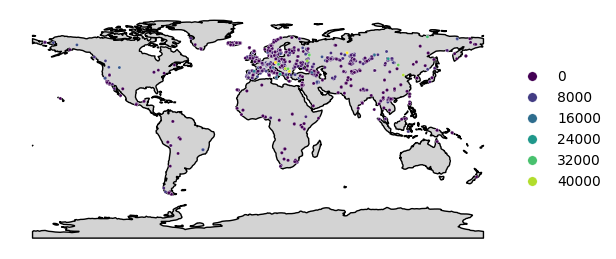

In [159]:
import seaborn as sns
import geopandas as gpd; import geodatasets
import sys
sys.path.append("../src/")
from src import legend_kwargs


world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

fig, ax = plt.subplots()
world.plot(
    edgecolor='k', facecolor='lightgrey',
    ax=ax,
    )


sns.scatterplot(md_combined, y="Latitude", x="Longitude", hue="Age average", palette="viridis", s=5, ax=ax)
ax.legend(markerscale=3,  **legend_kwargs())
ax.axis("off")
plt.show()
